In [1]:
from pydicom import dcmread
import numpy as np
import os
from matplotlib import pyplot as plt
import ipywidgets as widgets
from scipy import sparse
from progress.bar import Bar

In [3]:
folderPath = "/home/vik/Dokumente/Promotion/pCT/uncertainty-vis/Data/CHAOS/Train_Sets/MR/"
# subpath = "T2SPIR/DICOM_anon/"
subpath = "T1DUAL/DICOM_anon/InPhase"
setlist = [
	["1",slice(None, None, None)],
	["2",slice(None, None, None)],
	["3",slice(None, None, None)],
	["5",slice(None, None, None)],
	["8",slice(None, None, None)],
	["10",slice(None, None, None)],
	["13",slice(None, None, None)],
	["15",slice(None, None, None)],
	["19",slice(None, None, None)],
	["20",slice(None, None, None)],
	["21",slice(None, None, None)],
	["22",slice(None, None, None)],
	["31",slice(None, None, None)],
	["32",slice(None, None, None)],
	["33",slice(None, None, None)],
	["34",slice(None, None, None)],
	["36",slice(None, None, None)],
	["37",slice(None, None, None)],
	["38",slice(None, None, None)],
	["39",slice(None, None, None)],
]

In [21]:
target_shape = 256
persons = []
for person, extend in setlist:
    personPath = os.path.join(folderPath, person, subpath)
    scans = []
    scanFiles = os.listdir(personPath)
    scanFiles.sort()
    for item in scanFiles[extend]:
        scanPath = os.path.join(personPath, item)

        if os.path.isfile(scanPath):
            ds = dcmread(scanPath)
            current_shape = ds.pixel_array.shape[0]
            cut = (current_shape - target_shape) // 2
            img = ds.pixel_array
            scans.append( img[cut:target_shape + cut, cut:target_shape + cut] )

    persons.append( np.array(scans) )

In [22]:
@widgets.interact( pdx=( 0, len(persons) - 1, 1 ), idx=( 0, 100, 1 ) )
def show_scan(pdx=0, idx=0):
    print(persons[pdx].shape)
    plt.figure(figsize=(18,6))
    plt.imshow(persons[pdx][idx,:,:])
    plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=0, description='pdx', max=19), IntSlider(value=0, description='idx'), Ou…

In [52]:
z_dim = persons[0].shape[0]
ref = persons[0]
persons_aligned = []
for p in persons:
    if p.shape[0] < z_dim:
        z_dim = p.shape[0]
        ref = p

prog = 0
for p in persons:
    if p is ref:
        continue
    
    best = -1
    set = p
    print("Compute best fit for set", prog, " out of ", len(persons))
    prog += 1
    for i in range(0, p.shape[0] - z_dim):
        difference = ref - p[i:i+z_dim, :, :]
        error = np.mean(difference**2)
        
        if error > best:
            best = error
            set = p[i:i+z_dim, :, :]
    persons_aligned.append(set)

Compute best fit for set 0  out of  20
Compute best fit for set 1  out of  20
Compute best fit for set 2  out of  20
Compute best fit for set 3  out of  20
Compute best fit for set 4  out of  20
Compute best fit for set 5  out of  20
Compute best fit for set 6  out of  20
Compute best fit for set 7  out of  20
Compute best fit for set 8  out of  20
Compute best fit for set 9  out of  20
Compute best fit for set 10  out of  20
Compute best fit for set 11  out of  20
Compute best fit for set 12  out of  20
Compute best fit for set 13  out of  20
Compute best fit for set 14  out of  20
Compute best fit for set 15  out of  20
Compute best fit for set 16  out of  20
Compute best fit for set 17  out of  20
Compute best fit for set 18  out of  20


In [53]:
np.shape(persons_aligned)

(19, 26, 256, 256)

In [54]:
weight = 20
for i in range(weight-1):
    persons_aligned.append(persons_aligned[0])

persons_reshaped = np.transpose(persons_aligned, [1,2,3,0])
print( persons_reshaped.shape )

(26, 256, 256, 38)


In [55]:
mean = np.mean(persons_reshaped, axis=3)
print(mean.shape)
print(mean.dtype)
mean.tofile("/home/vik/Dokumente/Promotion/pCT/uncertainty-vis/Data/CHAOS/MRInmeanW" + str(weight) + ".raw")

(26, 256, 256)
float64


In [56]:
std = np.std(persons_reshaped, axis=3)
print(std.shape)
print(std.dtype)
std.tofile("/home/vik/Dokumente/Promotion/pCT/uncertainty-vis/Data/CHAOS/MRInstdW" + str(weight) + ".raw")

(26, 256, 256)
float64


In [49]:
@widgets.interact(idx=(0,mean.shape[0]-1,1))
def show_mean(idx=0):
    plt.figure(figsize=(18,6))
    plt.imshow(mean[idx,:,:])
    plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=0, description='idx', max=25), Output()), _dom_classes=('widget-interact…

# Dense Stacked Covariance Matrix
Creates a Covariance matrix for each point containing only the neighbors of the point. Thus, we get for each point a 8 times 8 covariance matrix.

In [92]:
def covPerCell(data, covArea = 0):
	data = np.asarray(data)
	covLength = 2 + 2 * covArea
	cov = []
	for z in range(data.shape[0] - 1):
		print("Computing covariance: ", z, " out of ", data.shape[2] - 1)
		plane = []
		for y in range(data.shape[1] - 1):
			row = []
			for x in range(data.shape[2] - 1):
				#cell = data[x:x+2,y:y+2,z:z+2,:]
				#cell = np.reshape(cell,(8,data.shape[3]))
				cell = data[max(0,x-covArea):min(data.shape[0],(x+covArea+2)),max(0,y-covArea):min(data.shape[1],(y+covArea+2)),max(0,z-covArea):min(data.shape[2],(z+covArea+2)),:]
				cell = np.reshape(cell,(cell.shape[0]*cell.shape[1]*cell.shape[2],data.shape[3]))
				matrix = np.cov(cell)
				for zi in range(covLength):
					for yi in range(covLength):
						for xi in range(covLength):
							index = zi * covLength * covLength + yi * covLength + xi
							if (x - xi + covArea + 1 < 0 or x + xi - covArea + 1 > data.shape[0] or
								y - yi + covArea + 1 < 0 or y + yi - covArea + 1 > data.shape[1] or
								z - zi + covArea + 1 < 0 or z + zi - covArea + 1 > data.shape[2]):
								matrix = np.insert(matrix, index, 0.0, axis=0)
								matrix = np.insert(matrix, index, 0.0, axis=1)
								#print(matrix.shape)
				#print(matrix.shape)
											
										
				row.append(matrix)
			plane.append(row)
		cov.append(plane)
	return np.array(cov)

In [93]:
cov = covPerCell(persons_reshaped)

Computing covariance:  0  out of  255
Computing covariance:  1  out of  255
Computing covariance:  2  out of  255
Computing covariance:  3  out of  255
Computing covariance:  4  out of  255
Computing covariance:  5  out of  255
Computing covariance:  6  out of  255
Computing covariance:  7  out of  255
Computing covariance:  8  out of  255
Computing covariance:  9  out of  255
Computing covariance:  10  out of  255
Computing covariance:  11  out of  255
Computing covariance:  12  out of  255
Computing covariance:  13  out of  255
Computing covariance:  14  out of  255
Computing covariance:  15  out of  255
Computing covariance:  16  out of  255
Computing covariance:  17  out of  255
Computing covariance:  18  out of  255
Computing covariance:  19  out of  255
Computing covariance:  20  out of  255
Computing covariance:  21  out of  255
Computing covariance:  22  out of  255
Computing covariance:  23  out of  255
Computing covariance:  24  out of  255
Computing covariance:  25  out of  

In [94]:
cov = np.swapaxes(cov, 0, 2)
print(cov.shape)
print(cov.dtype)

(255, 255, 80, 8, 8)
float64


In [100]:
cov.tofile("/home/vik/Dokumente/Promotion/pCT/uncertainty-vis/Data/covW" + str(weight) + ".raw")

# Sparse Covariance Matrix

In [57]:
N = np.prod(persons_reshaped.shape[:-1])
print(persons_reshaped.shape, N)
covarianceMatrix = sparse.lil_matrix((N, N))
print(covarianceMatrix.shape)

dim = persons_reshaped.shape[:-1]

with Bar(max=N, check_tty=False) as bar:
    for x in range(dim[0]):
        for y in range(dim[1]):
            for z in range(dim[2]):
                vertexId = np.int64( z + dim[2] * ( y + dim[1] * x ) )

                # go through the neighbors (if existent) and calculate the covariance
                # x axis
                if x - 1 >= 0:
                    otherId = np.int64( z + dim[2] * ( y + dim[1] * (x - 1) ) )
                    subset = np.stack([
                        persons_reshaped[x, y, z, :],
                        persons_reshaped[x - 1, y, z, :],
                    ])
                    covariance = np.cov(subset)

                    covarianceMatrix[vertexId, vertexId] = covariance[0,0]
                    covarianceMatrix[vertexId, otherId] = covariance[0,1]
                    covarianceMatrix[otherId, vertexId] = covariance[0,1]
                    covarianceMatrix[otherId, otherId] = covariance[1,1]
                if x + 1 < dim[0]:
                    otherId = np.int64( z + dim[2] * ( y + dim[1] * (x + 1) ) )
                    subset = np.stack([
                        persons_reshaped[x, y, z, :],
                        persons_reshaped[x + 1, y, z, :],
                    ])
                    covariance = np.cov(subset)

                    covarianceMatrix[vertexId, vertexId] = covariance[0,0]
                    covarianceMatrix[vertexId, otherId] = covariance[0,1]
                    covarianceMatrix[otherId, vertexId] = covariance[0,1]
                    covarianceMatrix[otherId, otherId] = covariance[1,1]

                # y axis
                if y - 1 >= 0:
                    otherId = np.int64( z + dim[2] * ( (y-1) + dim[1] * x ) )
                    subset = np.stack([
                        persons_reshaped[x, y, z, :],
                        persons_reshaped[x, y - 1, z, :],
                    ])
                    covariance = np.cov(subset)

                    covarianceMatrix[vertexId, vertexId] = covariance[0,0]
                    covarianceMatrix[vertexId, otherId] = covariance[0,1]
                    covarianceMatrix[otherId, vertexId] = covariance[0,1]
                    covarianceMatrix[otherId, otherId] = covariance[1,1]
                if y + 1 < dim[1]:
                    otherId = np.int64( z + dim[2] * ( (y+1) + dim[1] * x ) )
                    subset = np.stack([
                        persons_reshaped[x, y, z, :],
                        persons_reshaped[x, y + 1, z, :],
                    ])
                    covariance = np.cov(subset)

                    covarianceMatrix[vertexId, vertexId] = covariance[0,0]
                    covarianceMatrix[vertexId, otherId] = covariance[0,1]
                    covarianceMatrix[otherId, vertexId] = covariance[0,1]
                    covarianceMatrix[otherId, otherId] = covariance[1,1]

                # z axis
                if z - 1 >= 0:
                    otherId = np.int64( (z-1) + dim[2] * ( y + dim[1] * x ) )
                    subset = np.stack([
                        persons_reshaped[x, y, z, :],
                        persons_reshaped[x, y, z - 1, :],
                    ])
                    covariance = np.cov(subset)

                    covarianceMatrix[vertexId, vertexId] = covariance[0,0]
                    covarianceMatrix[vertexId, otherId] = covariance[0,1]
                    covarianceMatrix[otherId, vertexId] = covariance[0,1]
                    covarianceMatrix[otherId, otherId] = covariance[1,1]
                if z + 1 < dim[2]:
                    otherId = np.int64( (z+1) + dim[2] * ( y + dim[1] * x ) )
                    subset = np.stack([
                        persons_reshaped[x, y, z, :],
                        persons_reshaped[x, y, z + 1, :],
                    ])
                    covariance = np.cov(subset)

                    covarianceMatrix[vertexId, vertexId] = covariance[0,0]
                    covarianceMatrix[vertexId, otherId] = covariance[0,1]
                    covarianceMatrix[otherId, vertexId] = covariance[0,1]
                    covarianceMatrix[otherId, otherId] = covariance[1,1]

                # xy diagonals
                if x - 1 >= 0 and y - 1 >= 0:
                    otherId = np.int64( z + dim[2] * ( (y - 1) + dim[1] * (x - 1) ) )
                    subset = np.stack([
                        persons_reshaped[x, y, z, :],
                        persons_reshaped[x - 1, y - 1, z, :],
                    ])
                    covariance = np.cov(subset)

                    covarianceMatrix[vertexId, vertexId] = covariance[0,0]
                    covarianceMatrix[vertexId, otherId] = covariance[0,1]
                    covarianceMatrix[otherId, vertexId] = covariance[0,1]
                    covarianceMatrix[otherId, otherId] = covariance[1,1]
                if x + 1 < dim[0] and y + 1 < dim[1]:
                    otherId = np.int64( z + dim[2] * ( (y + 1) + dim[1] * (x + 1) ) )
                    subset = np.stack([
                        persons_reshaped[x, y, z, :],
                        persons_reshaped[x + 1, y + 1, z, :],
                    ])
                    covariance = np.cov(subset)

                    covarianceMatrix[vertexId, vertexId] = covariance[0,0]
                    covarianceMatrix[vertexId, otherId] = covariance[0,1]
                    covarianceMatrix[otherId, vertexId] = covariance[0,1]
                    covarianceMatrix[otherId, otherId] = covariance[1,1]
                if x + 1 < dim[0] and y - 1 >= 0:
                    otherId = np.int64( z + dim[2] * ( (y - 1) + dim[1] * (x + 1) ) )
                    subset = np.stack([
                        persons_reshaped[x, y, z, :],
                        persons_reshaped[x + 1, y - 1, z, :],
                    ])
                    covariance = np.cov(subset)

                    covarianceMatrix[vertexId, vertexId] = covariance[0,0]
                    covarianceMatrix[vertexId, otherId] = covariance[0,1]
                    covarianceMatrix[otherId, vertexId] = covariance[0,1]
                    covarianceMatrix[otherId, otherId] = covariance[1,1]
                if x + 1 < dim[0] and y - 1 > 0:
                    otherId = np.int64( z + dim[2] * ( (y - 1) + dim[1] * (x + 1) ) )
                    subset = np.stack([
                        persons_reshaped[x, y, z, :],
                        persons_reshaped[x + 1, y - 1, z, :],
                    ])
                    covariance = np.cov(subset)

                    covarianceMatrix[vertexId, vertexId] = covariance[0,0]
                    covarianceMatrix[vertexId, otherId] = covariance[0,1]
                    covarianceMatrix[otherId, vertexId] = covariance[0,1]
                    covarianceMatrix[otherId, otherId] = covariance[1,1]

                # xy diagonals below
                if x - 1 >= 0 and y - 1 >= 0 and z - 1 >= 0:
                    otherId = np.int64( (z - 1) + dim[2] * ( (y - 1) + dim[1] * (x - 1) ) )
                    subset = np.stack([
                        persons_reshaped[x, y, z, :],
                        persons_reshaped[x - 1, y - 1, z - 1, :],
                    ])
                    covariance = np.cov(subset)

                    covarianceMatrix[vertexId, vertexId] = covariance[0,0]
                    covarianceMatrix[vertexId, otherId] = covariance[0,1]
                    covarianceMatrix[otherId, vertexId] = covariance[0,1]
                    covarianceMatrix[otherId, otherId] = covariance[1,1]
                if x + 1 < dim[0] and y + 1 < dim[1] and z - 1 >= 0:
                    otherId = np.int64( (z - 1) + dim[2] * ( (y + 1) + dim[1] * (x + 1) ) )
                    subset = np.stack([
                        persons_reshaped[x, y, z, :],
                        persons_reshaped[x + 1, y + 1, z - 1, :],
                    ])
                    covariance = np.cov(subset)

                    covarianceMatrix[vertexId, vertexId] = covariance[0,0]
                    covarianceMatrix[vertexId, otherId] = covariance[0,1]
                    covarianceMatrix[otherId, vertexId] = covariance[0,1]
                    covarianceMatrix[otherId, otherId] = covariance[1,1]
                if x + 1 < dim[0] and y - 1 >= 0 and z - 1 >= 0:
                    otherId = np.int64( (z - 1) + dim[2] * ( (y - 1) + dim[1] * (x + 1) ) )
                    subset = np.stack([
                        persons_reshaped[x, y, z, :],
                        persons_reshaped[x + 1, y - 1, z - 1, :],
                    ])
                    covariance = np.cov(subset)

                    covarianceMatrix[vertexId, vertexId] = covariance[0,0]
                    covarianceMatrix[vertexId, otherId] = covariance[0,1]
                    covarianceMatrix[otherId, vertexId] = covariance[0,1]
                    covarianceMatrix[otherId, otherId] = covariance[1,1]
                if x + 1 < dim[0] and y - 1 > 0 and z - 1 >= 0:
                    otherId = np.int64( (z - 1) + dim[2] * ( (y - 1) + dim[1] * (x + 1) ) )
                    subset = np.stack([
                        persons_reshaped[x, y, z, :],
                        persons_reshaped[x + 1, y - 1, z - 1, :],
                    ])
                    covariance = np.cov(subset)

                    covarianceMatrix[vertexId, vertexId] = covariance[0,0]
                    covarianceMatrix[vertexId, otherId] = covariance[0,1]
                    covarianceMatrix[otherId, vertexId] = covariance[0,1]
                    covarianceMatrix[otherId, otherId] = covariance[1,1]

                # xy diagonals above
                if x - 1 >= 0 and y - 1 >= 0 and z + 1 < dim[2]:
                    otherId = np.int64( (z + 1) + dim[2] * ( (y - 1) + dim[1] * (x - 1) ) )
                    subset = np.stack([
                        persons_reshaped[x, y, z, :],
                        persons_reshaped[x - 1, y - 1, z + 1, :],
                    ])
                    covariance = np.cov(subset)

                    covarianceMatrix[vertexId, vertexId] = covariance[0,0]
                    covarianceMatrix[vertexId, otherId] = covariance[0,1]
                    covarianceMatrix[otherId, vertexId] = covariance[0,1]
                    covarianceMatrix[otherId, otherId] = covariance[1,1]
                if x + 1 < dim[0] and y + 1 < dim[1] and z + 1 < dim[2]:
                    otherId = np.int64( (z + 1) + dim[2] * ( (y + 1) + dim[1] * (x + 1) ) )
                    subset = np.stack([
                        persons_reshaped[x, y, z, :],
                        persons_reshaped[x + 1, y + 1, z + 1, :],
                    ])
                    covariance = np.cov(subset)

                    covarianceMatrix[vertexId, vertexId] = covariance[0,0]
                    covarianceMatrix[vertexId, otherId] = covariance[0,1]
                    covarianceMatrix[otherId, vertexId] = covariance[0,1]
                    covarianceMatrix[otherId, otherId] = covariance[1,1]
                if x + 1 < dim[0] and y - 1 >= 0 and z + 1 < dim[2]:
                    otherId = np.int64( (z + 1) + dim[2] * ( (y - 1) + dim[1] * (x + 1) ) )
                    subset = np.stack([
                        persons_reshaped[x, y, z, :],
                        persons_reshaped[x + 1, y - 1, z + 1, :],
                    ])
                    covariance = np.cov(subset)

                    covarianceMatrix[vertexId, vertexId] = covariance[0,0]
                    covarianceMatrix[vertexId, otherId] = covariance[0,1]
                    covarianceMatrix[otherId, vertexId] = covariance[0,1]
                    covarianceMatrix[otherId, otherId] = covariance[1,1]
                if x + 1 < dim[0] and y - 1 > 0 and z + 1 < dim[2]:
                    otherId = np.int64( (z + 1) + dim[2] * ( (y - 1) + dim[1] * (x + 1) ) )
                    subset = np.stack([
                        persons_reshaped[x, y, z, :],
                        persons_reshaped[x + 1, y - 1, z + 1, :],
                    ])
                    covariance = np.cov(subset)

                    covarianceMatrix[vertexId, vertexId] = covariance[0,0]
                    covarianceMatrix[vertexId, otherId] = covariance[0,1]
                    covarianceMatrix[otherId, vertexId] = covariance[0,1]
                    covarianceMatrix[otherId, otherId] = covariance[1,1]
                    
                bar.next()
            

(26, 256, 256, 38) 1703936


 |                                | 244/1703936

(1703936, 1703936)


 |################################| 1703936/1703936


In [58]:
sparse.save_npz('/home/vik/Dokumente/Promotion/pCT/uncertainty-vis/Data/CHAOS/MRInSigmaW20.npz', covarianceMatrix.todia())

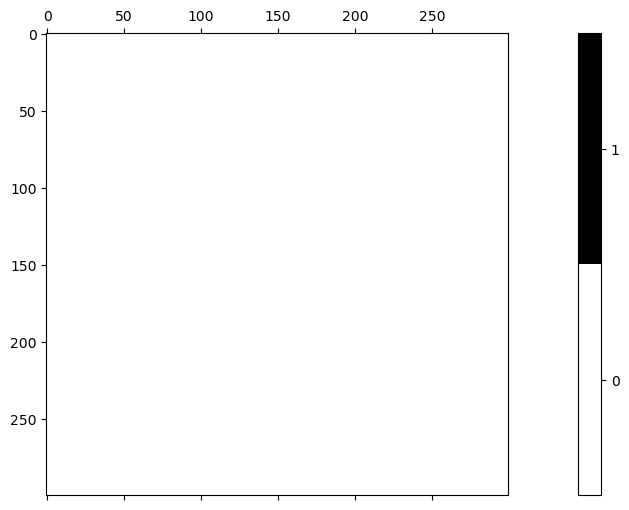

In [60]:
plt.figure(figsize=(18,6))
plt.spy(covarianceMatrix[:300,:300].toarray())
plt.colorbar()
plt.show()